<h1>Import Libraries</h1>

In [86]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import h5py

In [88]:
sys.path.append("../../WatChMaL_analysis_copy")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc, compute_roc, plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output, collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_mu_fq_output, load_pion_fq_output, load_gamma_fq_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices
from WatChMaL.analysis.performance_analysis_plot_utils import plot_fitqun_binned_performance, plot_momentum_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_true_momentum_binned_performance, plot_to_wall_binned_performance, plot_energy_binned_performance, plot_zenith_binned_performance, plot_azimuth_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_in_energy, plot_zenith_binned_in_azimuth, plot_azimuth_binned_in_zenith

In [89]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi 0$":3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:"$\pi 0$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

<h1>Load fiTQun Results</h1>

In [90]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
pion_file_path  = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

fq_mapping_path = '/home/zpatel/zp_analysis_notebooks/cuts/4_class_3M_fitqun_mapping.pickle'

with open('/home/zpatel/zp_analysis_notebooks/cuts/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

In [91]:
# fq_mapping_path = '/home/zpatel/WatChMaL_analysis_copy/fitqun_comparison/fitqun_comparison_prep/prep_data/4_class_3M_fitqun_mapping.pickle'
# with open('/home/zpatel/WatChMaL_analysis_copy/fitqun_comparison/fitqun_comparison_prep/prep_data/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
#     cuts = pickle.load(handle)

<h1>Load ResNet Results</h1>

In [92]:
############# define run locations #############
short_locs = [
#                 '/home/zpatel/WatChMaL/outputs/2021-06-07/09-32-54/outputs', #ZP run #1 
#                 '/home/zpatel/WatChMaL/outputs/2021-06-14/09-33-32/outputs',  #ZP run #2
#                 '/home/zpatel/WatChMaL/outputs/2021-06-14/10-02-07/outputs',   #ZP run #3
#                     '/home/zpatel/zp_analysis_notebooks/JT_4_class_training/outputs', #JT outputs from full config file (train and test) but doesn't work (different length arrays)
#                   '/home/zpatel/WatChMaL/outputs/2021-06-14/13-27-06/outputs',  #JT weights with ZP testing config
#                 '/home/zpatel/zp_analysis_notebooks/outputs_4_class_JT/',     #JT 4-class
#                 '/home/zpatel/WatChMaL/outputs/2021-06-15/10-30-10/outputs', #ZP weights (ZP train/test config) with JT testing 
                '/home/zpatel/WatChMaL/outputs/2021-06-16/09-59-14/outputs', #ZP weights using JT train/test config, JT test config
#                 '/home/zpatel/WatChMaL/outputs/2021-06-16/10-49-03/outputs', #JT weights trained on Jt test config
#                 '/home/zpatel/WatChMaL/outputs/2021-06-29/12-02-12/outputs', #ZP weights with padding
#                     '/home/zpatel/WatChMaL/outputs/2021-07-16/10-00-28/outputs', #ZP weights trained on Jt train/test config with padding, with correct horiz padding
#                 '/home/zpatel/WatChMaL/outputs/2021-07-21/10-47-52/outputs', #padded data
                '/home/zpatel/zp_analysis_notebooks/outputs_2_class_JT/'     #JT 2-class
              ]

short_titles = ['Short Tank (4-class)', 'Short Tank (2-class)', 'Fitqun'] # Includes 2-Class

full_locs = []

full_titles = []

short_linecolor = [c[0] for _ in range(2)]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[1] for _ in full_locs]
full_linestyle = [':' for _ in full_locs]

In [93]:
############# load short tank run data #############
short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]
raw_indices = [np.load(loc + "/indices.npy") for loc in short_locs]

In [94]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

<h1>Load h5 Data</h1>

In [95]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

energies   = np.array(data_file['energies'])
angles     = np.array(data_file['angles'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [96]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs  = idxs['test_idxs']

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]

In [97]:
test_energies.shape

(4671749, 1)

Reorder test labels.

In [98]:
test_labels = test_labels[raw_indices[0]]

In [99]:
from collections import OrderedDict

In [100]:
print(list(OrderedDict.fromkeys(labels)))
print(list(OrderedDict.fromkeys(labels[test_idxs])))
print(list(OrderedDict.fromkeys(test_labels)))
print(list(OrderedDict.fromkeys(short_raw_actual_labels[0])))

[1, 0, 2, 3]
[1, 2, 0, 3]
[1, 0, 2, 3]
[1, 0, 2, 3]


In [101]:
raw_indices[0]

array([      0,       1,       2, ..., 4671746, 4671747, 4671748])

Both <Code>test_d_to_wall</Code> and <Code>test_true_mom</Code> must have their indices swapped to match the 4-class model softmax order. 

In [102]:
d_to_wall = np.load('/home/zpatel/WatChMaL_analysis_copy/fitqun_comparison/fitqun_comparison_prep/prep_data/3M_d_to_wall.npz', allow_pickle=True)

test_d_to_wall  = d_to_wall['test_d_to_wall'][raw_indices[0]]

In [103]:
true_mom = np.load('/home/zpatel/WatChMaL_analysis_copy/fitqun_comparison/fitqun_comparison_prep/prep_data/3M_momenta.npz', allow_pickle=True)

test_true_mom  = true_mom['test_momenta'][raw_indices[0]]

<h1>Verify Indices</h1>

In [104]:
e_gamma_4_class_idxs = np.where((test_labels == 0) | (test_labels == 1))[0]

In [105]:
print(np.bincount(short_raw_actual_labels[0]))
print(np.bincount(short_raw_actual_labels[1])) # 2-Class
print(np.bincount(test_labels))
print(np.bincount(test_labels[e_gamma_4_class_idxs]))

[1182377 1177966 1164139 1147267]
[1182377 1177966]
[1182377 1177966 1164139 1147267]
[1182377 1177966]


In [106]:
row_maxes = short_raw_output_softmax[0].max(axis=1).reshape(-1, 1)
softmax_bins = np.where(short_raw_output_softmax[0] == row_maxes, 1, 0)

In [107]:
softmax_bins

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

<h1>Generate Muon Rejection-Based Preselection</h1>

<h2>Load 4-class with muons</h2>

In [108]:
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

In [109]:
muon_cut_to_apply = cuts['fq_comparison_swap']

muon_raw_short_softmax = short_raw_output_softmax[0]

muon_filtered_short_softmax  = remove_indices(short_raw_output_softmax[0], muon_cut_to_apply)
muon_filtered_labels         = remove_indices(short_raw_actual_labels[0], muon_cut_to_apply)

muon_collapsed_class_scores, muon_collapsed_class_labels = collapse_test_output(muon_filtered_short_softmax, muon_filtered_labels, label_dict, ignore_type='$\gamma$')

muon_collapsed_class_scores = muon_collapsed_class_scores[:,1:]
muon_collapsed_class_labels = muon_collapsed_class_labels - 1 

In [110]:
muon_filtered_short_softmax.shape, muon_filtered_labels.shape, label_dict

((1983641, 4),
 (1983641,),
 {'$\\gamma$': 0, '$e$': 1, '$\\mu$': 2, '$\\pi 0$': 3})

In [111]:
print(len(muon_collapsed_class_labels))

1005732


In [112]:
print(len(muon_collapsed_class_labels))

1005732


<h2>Cuts</h2>

<p>As the electron neutrino flux is a small component of the total neutrino flux, electron neutrino interaction events make up only 1.5% of all interaction events in the detector. In order to make precise measurements of electron neutrino cross-sections it is necessary to select a sample of events enriched in electron neutrino interactions. These events must be selected based upon the properties of the event as reconstructed by the detector.</p>

<h2> Compute Threshold </h2>

Choose a threshold as close to fpr_fixed_point = 0.005 as possible. To do this, compute index of min(fprs - 0.005) to find the false positive rate closest to the fixed point of 0.005. The index of this FPR will provide the threshold.

In [113]:
fpr_fixed_point = 0.005
fprs, tprs, thrs = compute_roc(muon_collapsed_class_scores, muon_collapsed_class_labels,
                            true_label=muon_softmax_index_dict["e/gamma"],
                            false_label=muon_softmax_index_dict["mu"],
                            normalize=True)

operating_point_thr = thrs[np.argmin(np.abs(fprs - fpr_fixed_point))]

operating_point_cut = ((muon_raw_short_softmax[:, 0] + muon_raw_short_softmax[:, 1])/(muon_raw_short_softmax[:, 0] + muon_raw_short_softmax[:, 1] + muon_raw_short_softmax[:, 2])) < operating_point_thr

print(tprs[np.argmin(np.abs(fprs - fpr_fixed_point))])
print(fprs[np.argmin(np.abs(fprs - fpr_fixed_point))])

0.9842597390232872
0.0050005113664800364


In [114]:
# Verify cut working
comp_idxs = np.where((muon_filtered_labels == 1 ) | (muon_filtered_labels == 2))[0]

scores = ((muon_filtered_short_softmax[:, 0] + muon_filtered_short_softmax[:, 1])/(muon_filtered_short_softmax[:, 0] + muon_filtered_short_softmax[:, 1] + muon_filtered_short_softmax[:, 2]))

pred_pos_idxs = np.where( scores[comp_idxs] >= operating_point_thr)[0]
pred_neg_idxs = np.where( scores[comp_idxs] < operating_point_thr)[0]

true_label, false_label = '$e$','$\mu$'
fp = np.where(muon_filtered_labels[comp_idxs[pred_pos_idxs]] == label_dict[false_label])[0].shape[0]
tp = np.where(muon_filtered_labels[comp_idxs[pred_pos_idxs]] == label_dict[true_label] )[0].shape[0]
fn = np.where(muon_filtered_labels[comp_idxs[pred_neg_idxs]] == label_dict[true_label] )[0].shape[0]
tn = np.where(muon_filtered_labels[comp_idxs[pred_neg_idxs]] == label_dict[false_label])[0].shape[0]

# Fix division by zero
efficiency = performance = tp/(tp + fn + 1e-10)
fpr = performance = fp/(fp + tn + 1e-10)

print(efficiency)
print(fpr)

0.984259739023287
0.005000511366480035


In [115]:
fp, tp, fn, tn

(2298, 537582, 8597, 457255)

In [116]:
fp + tp + tn + fn 

1005732

<h1>Test Cut</h1>

<h2>Plot ROC</h2>

<h3>Without Muon Preselection</h3>

In [117]:
cut_to_apply = cuts['fq_comparison_swap']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

In [118]:
muon_preselection_short_softmax   = remove_indices(short_raw_output_softmax[0][e_gamma_4_class_idxs], cut_to_apply)
muon_preselection_filtered_labels = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], cut_to_apply)

In [119]:
fprs, tprs, thrs = compute_roc(muon_preselection_short_softmax, muon_preselection_filtered_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

In [120]:
fpr_list = [fprs] 
tpr_list = [tprs]
thr_list = [thrs]

gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun 1', 'Short Tank Fitqun 2', 'Short Tank Fitqun 3']

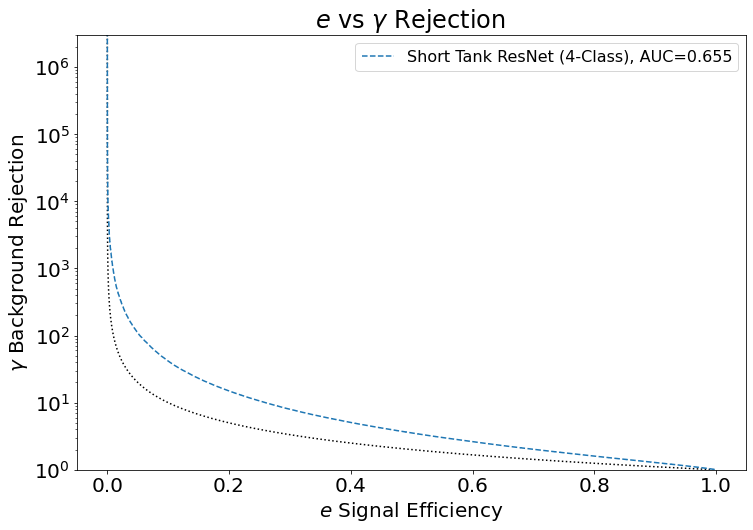

In [121]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

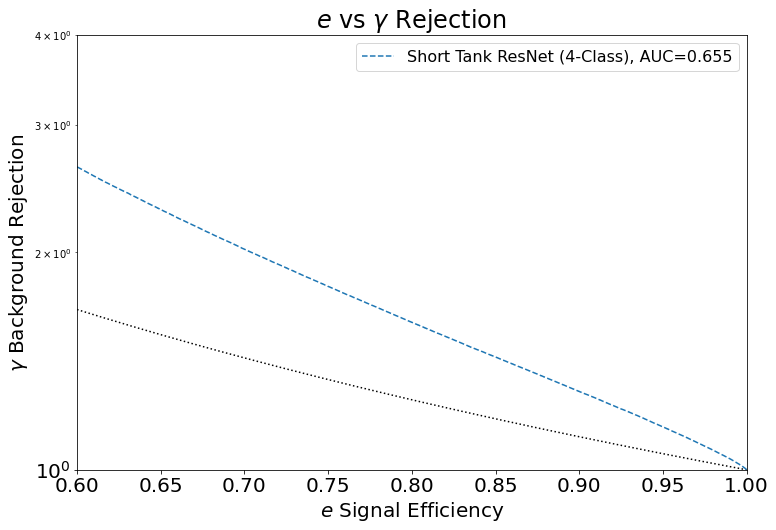

In [122]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

<h3>With Muon Preselection</h3>

In [123]:
cut_to_apply = cuts['fq_comparison_swap']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True

pre_muon_cuts = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

updated_cuts[operating_point_cut] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

# Compute preslection factors
pre_muon_preselection_labels  = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], pre_muon_cuts)
post_muon_preselection_labels = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], cut_to_apply)

print(len(pre_muon_preselection_labels))
print(len(post_muon_preselection_labels))

# Electron
efficiency_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 1]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 1])

print(efficiency_correction_factor)

# Gamma
rejection_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 0]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 0])

print(rejection_correction_factor)


1101872
1089151
0.9842597390232872
0.9925786360454424


In [124]:
muon_preselection_short_softmax   = remove_indices(short_raw_output_softmax[0][e_gamma_4_class_idxs], cut_to_apply)
muon_preselection_filtered_labels = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], cut_to_apply)

In [125]:
fprs, tprs, thrs = compute_roc(muon_preselection_short_softmax, muon_preselection_filtered_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

# Update using preselection statistics
tprs = tprs*efficiency_correction_factor
fprs = fprs*rejection_correction_factor

In [126]:
fpr_list = [fprs] 
tpr_list = [tprs]
thr_list = [thrs]

gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun 1', 'Short Tank Fitqun 2', 'Short Tank Fitqun 3']

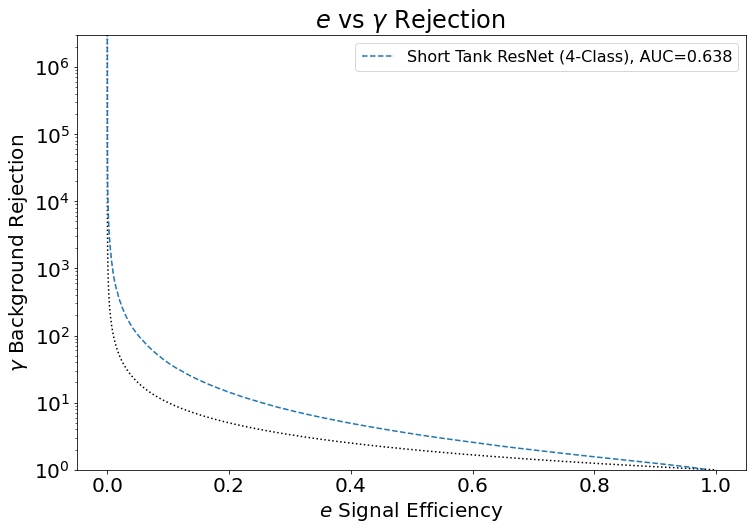

In [127]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

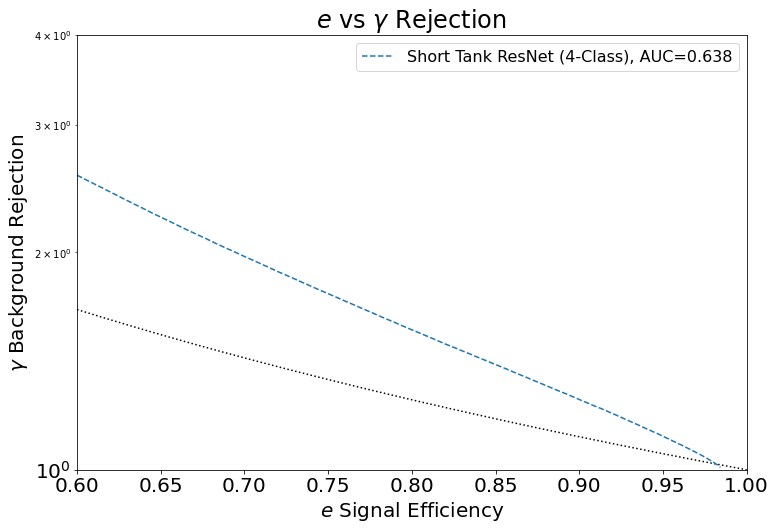

In [128]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

<h1>Plot Performance</h1>

<h2>Adding fiTQun Results</h2>

fiTQun results must be reordered to match indices.npy order.

In [129]:
fq_scores, fq_labels, fq_mom, fq_masses = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')
fq_scores = fq_scores[raw_indices[0]]
fq_labels = fq_labels[raw_indices[0]]
fq_mom = fq_mom[raw_indices[0]]
fq_masses = fq_masses[raw_indices[0]]

In [130]:
print(list(OrderedDict.fromkeys(fq_labels)))

[1.0, 0.0, 2.0, 3.0]


In [131]:
fq_scores.shape

(4671749, 3)

In [132]:
short_output_softmax = [short_raw_output_softmax[0][e_gamma_4_class_idxs], short_raw_output_softmax[1], fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = [short_raw_actual_labels[0][e_gamma_4_class_idxs] , short_raw_actual_labels[1], fq_labels[e_gamma_4_class_idxs]]

'''
short_output_softmax = [short_raw_output_softmax + [fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = [short_raw_actual_labels  + [fq_labels[e_gamma_4_class_idxs]]
'''

'\nshort_output_softmax = [short_raw_output_softmax + [fq_scores[e_gamma_4_class_idxs]]\nshort_actual_labels  = [short_raw_actual_labels  + [fq_labels[e_gamma_4_class_idxs]]\n'

<h2>Derive 2 class cuts from 4 class cuts</h2>

In [133]:
cut_to_apply = cuts['fq_comparison_swap']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True
updated_cuts[operating_point_cut] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

<h2>Filter Results</h2>

In [134]:
filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_list = [(filtered_short_softmax[0][:,1])/(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]),
               (filtered_short_softmax[1][:,1])/(filtered_short_softmax[1][:,0] + filtered_short_softmax[1][:,1]),
               filtered_short_softmax[2][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1], filtered_labels[2]]
names  = ['ResNet (4-class)', 'ResNet (2-class)', 'FiTQun']
colors = ['r', 'b', 'g']
fpr_rate = 0.2

In [135]:
fpr_rate

0.2

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$e$ Signal Efficiency'>

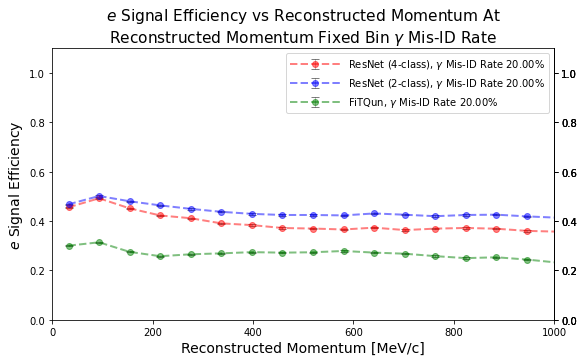

In [136]:
plot_momentum_binned_performance(
                                 reconstructed_momentum = filtered_fq_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='To Wall [cm]', ylabel='$e$ Signal Efficiency'>

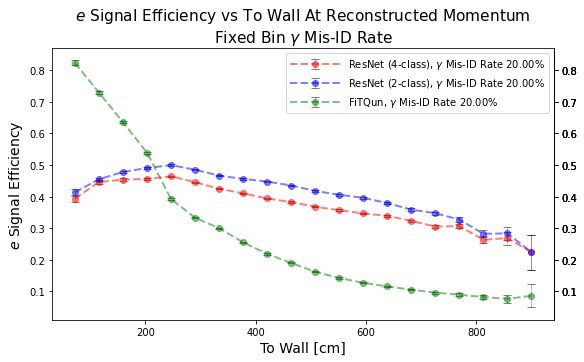

In [137]:
plot_to_wall_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 to_wall_features       = filtered_test_to_wall,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

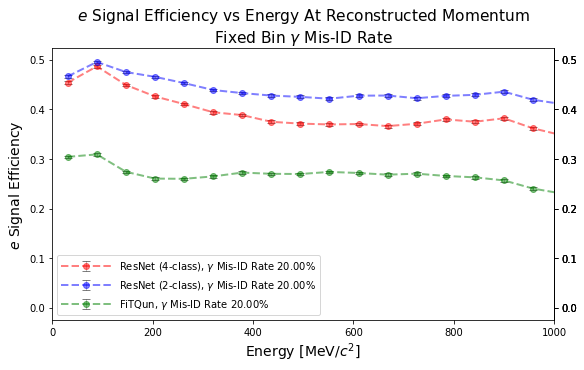

In [138]:
plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000],
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Zenith [Radians]', ylabel='$e$ Signal Efficiency'>

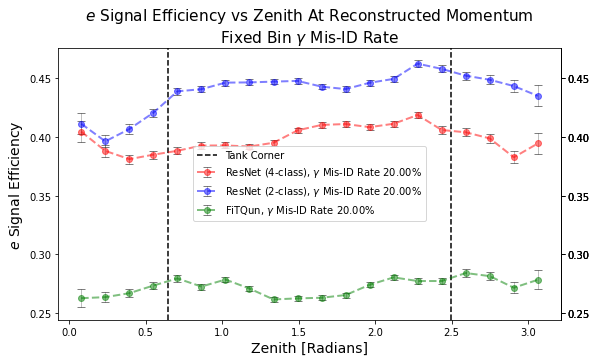

In [139]:
plot_zenith_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 zenith_features        = filtered_test_zenith,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

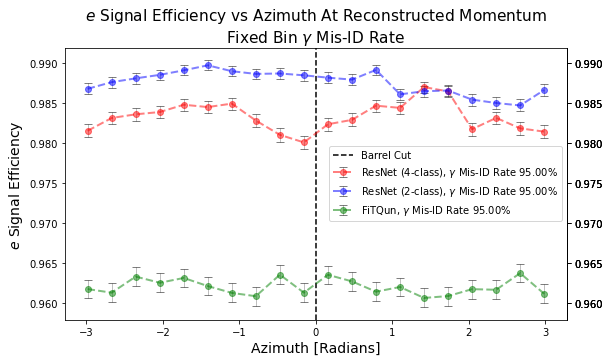

In [140]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.95, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

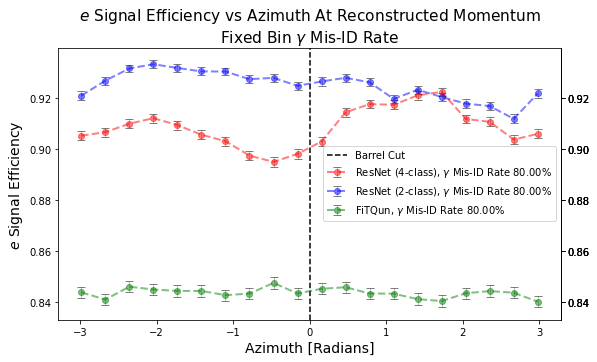

In [141]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.8, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

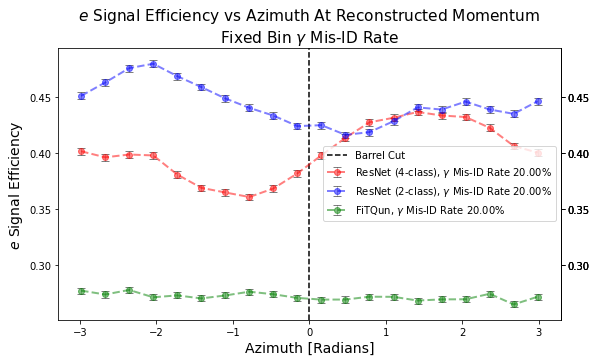

In [142]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.2, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

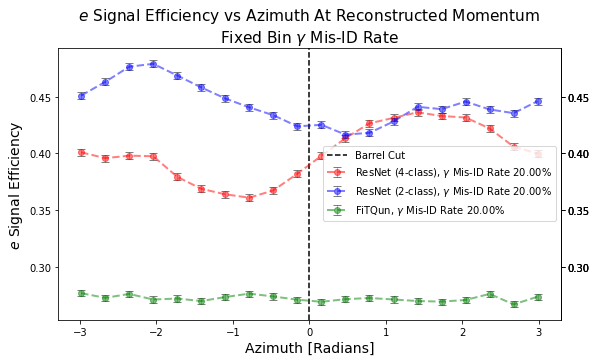

In [143]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.2, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

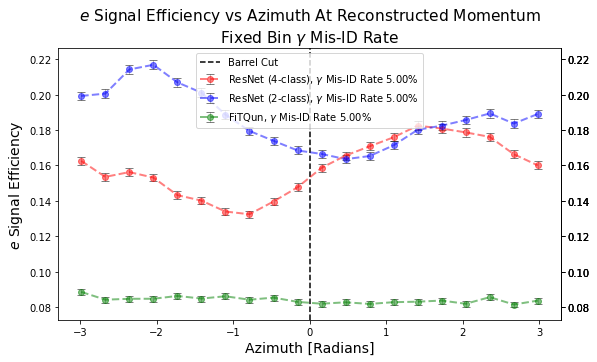

In [144]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.05, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<h1>Plot for Varying FPR</h1>

In [69]:
from WatChMaL.analysis.performance_analysis_plot_utils import plot_varying_efficiency

NameError: name 'scores_list' is not defined

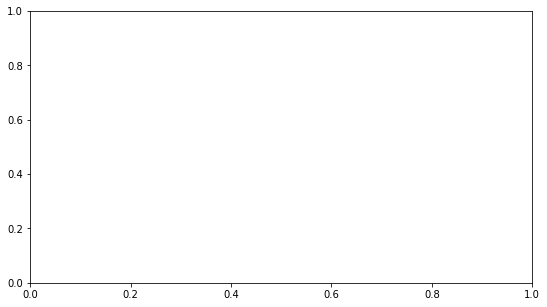

In [153]:
fig, ax = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_varying_efficiency(fprs                   = np.linspace(0.005, 0.95, 3),
                        plotting_function      = plot_momentum_binned_performance,
                        scores_list            = scores_list, 
                        labels_list            = labels_list,
                        reconstructed_momentum = filtered_fq_mom,
                        index_dict             = label_dict, 
                        recons_mom_bin_size    = 50, 
                        plot_bins              = 20,
                        title_note             = '',
                        names                  = names,
                        colors                 = colors,
                        desired_labels         = ['$e$','$\gamma$'],
                        ax                     = ax,
                        #yrange                 = [0.57, 0.73]
                       )

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_varying_efficiency(fprs                   = np.linspace(0.5, 0.95, 5),
                        plotting_function      = plot_azimuth_binned_performance,
                        scores_list            = scores_list, 
                        labels_list            = labels_list,
                        reconstructed_momentum = filtered_fq_mom,
                        azimuth_features       = filtered_test_azimuth,
                        index_dict             = label_dict, 
                        recons_mom_bin_size    = 50, 
                        plot_bins              = 20,
                        title_note             = '',
                        names                  = names,
                        colors                 = colors,
                        desired_labels         = ['$e$','$\gamma$'],
                        ax                     = ax,
                        #yrange                 = [0.57, 0.73]
                       )

NameError: name 'scores_list' is not defined

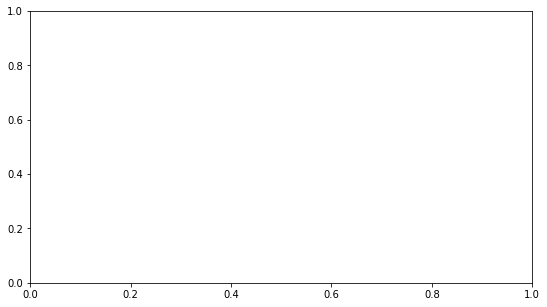

In [154]:
fig, ax = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_varying_efficiency(fprs                   = np.linspace(0.5, 0.95, 5),
                        plotting_function      = plot_azimuth_binned_performance,
                        scores_list            = [scores_list[0]], 
                        labels_list            = [labels_list[0]],
                        reconstructed_momentum = filtered_fq_mom,
                        azimuth_features       = filtered_test_azimuth,
                        index_dict             = label_dict, 
                        recons_mom_bin_size    = 50, 
                        plot_bins              = 20,
                        title_note             = '',
                        names                  = [names[0]],
                        colors                 = [colors[0]],
                        desired_labels         = ['$e$','$\gamma$'],
                        ax                     = ax,
                        #yrange                 = [0.57, 0.73]
                       )

<h1>Multiple Variable Plotting</h1>

IndexError: index 11 is out of bounds for axis 0 with size 11

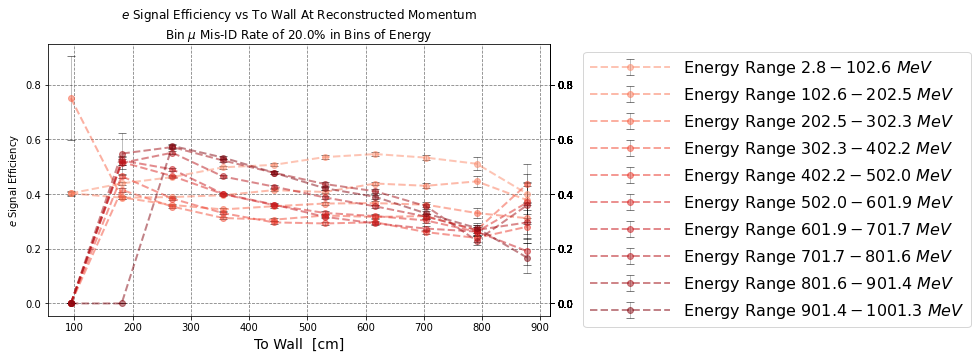

In [414]:
plot_to_wall_binned_in_energy(scores_list            = scores_list, 
                              labels_list            = labels_list,
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_energies,
                              binning_bin_size       = 200,
                              to_wall_features       = filtered_test_to_wall,
                              fpr_fixed_point        = fpr_rate, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              colors                 = colors,
                              desired_labels         = ['$e$','$\gamma$']
                              )

In [ ]:
plot_azimuth_binned_in_zenith(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_zenith,
                                  binning_bin_size       = 0.5,
                                  azimuth_features       = filtered_test_azimuth,
                                  fpr_fixed_point        = fpr_rate, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  colors                 = colors,
                                  desired_labels         = ['$e$','$\gamma$']
                                  )

In [ ]:
plot_zenith_binned_in_azimuth(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_azimuth,
                                  binning_bin_size       = 0.5,
                                  zenith_features        = filtered_test_zenith,
                                  fpr_fixed_point        = fpr_rate, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  colors                 = colors,
                                  desired_labels         = ['$e$','$\gamma$'] 
                                  )